In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy import linalg

#Sparse Methods#

Most physical Hamiltonians of interest can be represented as sparse matrices, because interactions are local and/or few-body. Working with sparse matrices can often lead to big gains in memory usage and/or speed.  

There are many different sparse matrix formats supported by scipy. The ones we'll use most often are:

1. Compressed sparse row (CSR)
2. Compressed sparse column (CSC)
3. Diagonal (DIA)

Try typing sparse.ma and hit tab to auto-complete to see all the different types.

##Pauli Matrices ##

Most models we will consider in this course represent systems of spin-S degrees of freedom living on some $d$ dimensional lattice in real space with volume $V= L^d$ . For $S=1/2$, the spin on each site can be either 'up' or 'down', representing a $2^V$ dimensional Hilbert space. This exponential growth of the Hilbert space dimension is one primary challenge in numerically studying many-body quantum systems.

For $S=1/2$ systems, a complete basis of operators is generated by the Pauli matrices on each site.

In [ ]:
Id = sparse.eye(2)
sx = sparse.csr_matrix(np.array([[0,1.],[1,0]]))
sz = sparse.csr_matrix(np.array([[1,0.],[0,-1]]))
sy = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))

In [ ]:
sx

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
sx.toarray()

array([[0., 1.],
       [1., 0.]])

Note: Sparse matrix multiplication is implemented by using *. This is different from dense numpy arrays where * represents element wise multiplication

In [ ]:
(sz*sx).toarray()

array([[ 0.,  1.],
       [-1.,  0.]])

In [ ]:
(sz.toarray())*(sx.toarray())

array([[ 0.,  0.],
       [ 0., -0.]])

In [ ]:
(sz.toarray()).dot((sx.toarray()))

array([[ 0.,  1.],
       [-1.,  0.]])

We will be interested in the many-body physics of systems of many-spins. In such systems, $\sigma_i^x = \cdots \mathbb{1}\otimes\mathbb{1} \otimes \sigma^x \otimes \mathbb{1} \otimes \mathbb{1} \cdots$.  This is a very sparse matrix when represented on the full Hilbert space

In [ ]:
sparse.kron(sx,Id).toarray()

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
sparse.kron(sparse.kron(sx,Id), Id).toarray()

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
sparse.kron(sparse.kron(sx,Id), Id).count_nonzero()

8

It is convenient to build up lists of Pauli matrices on each site, which can then be used to construct any spin 1/2 Hamiltonian we desire:

In [ ]:
def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype=complex)
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list

In [ ]:
s0, x,y,z= gen_s0sxsysz(4)

In [ ]:
x

[<16x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 16 stored elements in Compressed Sparse Row format>,
 <16x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 16 stored elements in Compressed Sparse Row format>,
 <16x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 16 stored elements in Compressed Sparse Row format>,
 <16x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 16 stored elements in Compressed Sparse Row format>]

## Diagonalizing the 1D transverse-field Ising model##

The transverse field Ising model (TFIM) is a paradigmatic model in statistical physics. This model will appear over and over during the course of these lectures. The Hamiltonian in one dimension is:

$$H = -J \sum_i \sigma_i^z \sigma_{i+1}^z - h \sum_i \sigma_i^x$$


Don't fret if you haven't seen this before. We'll introduce it in detail in a future lecture. For now, you should know that the ground state of $H$ is ferromagnetically ordered when $J > h$, is a paramagnet for $h>J$ and the system undergoes a quantum phase transiton at $h=J$.

# Exercises (15 pts)

1. How many non-zero entries does $\sigma_i^x$ have in a one dimensional system of length $L$ (working in the basis of $\sigma_i^z$ eigenstates? (3 pt)

2. Write a function Hbond(L) which takes as input $L$ and returns a $2^L x 2^L$ matrix representing the bond interaction term $\sum_i \sigma_i^z\sigma_{i+1}^z$, computed using "brute force" for loops over the full basis of $2^L$ states. You can use open boundary conditions. (3pts)

3. Write a function Hfield(L) which takes as input $L$ and returns a $2^L x 2^L$ matrix representing the onsite field term $\sum_i \sigma_i^x$, computed using "brute force" for loops over the full basis of $2^L$ states (3pts)

4. Use the lists of sparse Pauli operators to write functions Hbond_sparse and Hfield_sparse which obtain Hfield and Hbond using sparse methods. (3 pts)


**1.** For a system of size $L$, there are $2^L$ basis states, since every qubit has dimension 2 and there are $L$ qubits. Working in the basis of $Z$ eigenenstates, the matrix elements of an operator are $\langle n |A | m \rangle $, where $|n\rangle, |m\rangle$ are $Z$ basis states.

We can find the matrix elements of an operator by acting on a basis state with it and then representing the newly generated state in as a superposition of the basis states: $A|m\rangle = \sum_n c_n |n \rangle$. Then, a matrix element of $A$ is $\langle n |A | m \rangle = c_n$.

Consider the action of $\sigma_i^x$ on a $Z$ basis state. This operator will flip the orientation of the spin on site $i$. Then for each of the $2^L$ basis states, there is only a single new basis state on which the newly generated state has amplitude. Said another way, given an $|n \rangle$ there is only a single $|m\rangle$ for which $\langle n |A | m \rangle \neq 0$.

Thus, there are $2^L$ non-zero elements of $\sigma_i^x$ in the $Z$ basis of $L$ qubits.

**2.** This operator is diagonal in the $Z$ basis. Therefore, even though we are using brute force methods to generate the Hbond here, we can be clever. We can simply note the value of $A = \sum_i \sigma_i^z\sigma_{i+1}^z$ for each of the basis states and then assign values down the diagonal. Note that the method written below is for periodic boundary conditions.

In [ ]:
def Hbond(L, bcs = 'pbc'):
  H = np.zeros((2**L, 2**L))
  if bcs == 'pbc':
    # Since each of the basis states is a binary string, we may loop from 1 to 2^L and perform bit operations to get the desired value of the operator.
    for i in range(2**L):
      rotated_value = ((i >> 1) | (i << (L - 1))) & ((1 << L) - 1) # Rotate the bits of the integer clockwise by 1, taking into account the length of the chain. e.g. 0001 -> 1000.
      neighbor_parities = i ^ rotated_value # xor the basis state against the rotated state. This will give us the parity between all nearest neighbors.
      pair_dn = bin(neighbor_parities).count('1') # Count the number of pairs of nearest neigbhor sites which are anti-aligned.
      H[i,i] = L - 2 * pair_dn # Each pair of sites with opposite parity will lower the value of Hbond by 2
  else:
    for i in range(2**L):
      rotated_value = i >> 1 #  Rotate the bits of the integer clockwise by 1 but without wrapping around.
      mask = ~(1 << L-1) # This will produce a bit string of the form 01111 so that when this is multiplied against another bitstring, only the left-most bit will become 0.
      num = i & mask # Set the left most bit equal to 0 so it doesn't contribute to count of anti-aligned pairs.
      neighbor_parities = num ^ rotated_value
      pair_dn = bin(neighbor_parities).count('1') # Count the number of pairs of nearest neigbhor sites which are anti-aligned.
      H[i,i] = L - 1 - 2 * pair_dn # Each pair of sites with opposite parity will lower the value of Hbond by 2. L-1 pairs when there are open boundary conditions.

  return H

**3.** Since the action of a term of this operator on a $Z$ basis state simply produces another $Z$ basis state, we can loop through each basis state $|n⟩$, operate on it with $\sigma^x_i$, and whichever state outputted is the state $|m⟩$ in $⟨m|\sigma_i^x|n⟩$. For each basis state, we just need to do this for each bit.

In [ ]:
def Hfield(L):
  H = np.zeros((2**L, 2**L))
  # Since each of the basis states is a binary string, we may loop from 1 to 2^L and perform bit operations to get the desired value of the operator.
  j = 0
  for i in range(2**L):
    # Since this operator is a sum over sigma^x, each sigma^x_j in the sum acts on the basis state to produce a new state. So, we must loop through all j between 0 and L.
    for j in range(L):
      mask = 1 << j # This will create a bit string with a 1 at the position we want to flip.
      new_num = i ^ mask # xor-ing this mask against the basis state will product a bit string with the qubit at position j flipped
      H[i, new_num] = 1 # the integer representation of the new state is the value of m in <m|sigma_i^x|n>.

  return H


There are many ways to do these problems, but learning to do bitwise operations is very useful. If you ever decide to do things like implement complicated symmetries like translation into your exact diagonalization program, you will need to do things like perform transformations between basis states which are most efficiently done with bitwise operations. A useful website that details how to do many of these is: https://graphics.stanford.edu/~seander/bithacks.html
Many other resources also exist to find out how to do your specific task.

**4.** Now we use sparse methods.

In [ ]:
def Hbond_sparse(L):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L) # Using the method from above.
  H = 0 * s0_list[0] # Quick way to initialize the matrix to the right dimension.
  for i in range(L): # Change this to L-1 if open boundary conditions are desired.
    H += sz_list[i] * sz_list[(i+1)%L] # Need the mod to loop back to site 0 when i = L-1.
  return H

def Hfield_sparse(L):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L) # Using the method from above.
  H = sum(sx_list) # The sum of all single site x operators
  return H


Let's check that both methods give the same answer

In [ ]:
L=8
Hb_spa = Hbond_sparse(L)
Hb_den = Hbond(L)
Hf_spa = Hfield_sparse(L)
Hf_den = Hfield(L)

print(np.max(abs(Hb_spa.toarray() - Hb_den)))
print(np.max(abs(Hf_spa.toarray() - Hf_den)))

0.0
0.0


At a quantum phase transition, the gap between the ground and first excited state goes to zero. Let's look at this.

5. Set $J=1, L=8$. Construct the Hamiltonian using sparse methods i.e. using the functions Hbond_sparse and Hfield_sparse defined above. Obtain and plot the lowest two energy eigenvalues of the Hamiltonian as a function of $H$. Do do this, you can the Hamiltonian to a dense matrix using .toarray() function, and then use linalg.eigvalsh to obtain the eigenvalues of the dense matrix. Do you see the gap closing at $h=0$? (3 pts)

In [ ]:
J = 1
L = 8
hrange = np.logspace(-1,1,10)
gs = []
es = []
es2 = []
es3 = []
for h in hrange:
  H = J * Hbond_sparse(L) + h * Hfield_sparse(L)
  evals = np.linalg.eigvalsh(H.todense())
  gs.append(evals[0])
  es.append(evals[1])
  es2.append(evals[2])
  es3.append(evals[3])

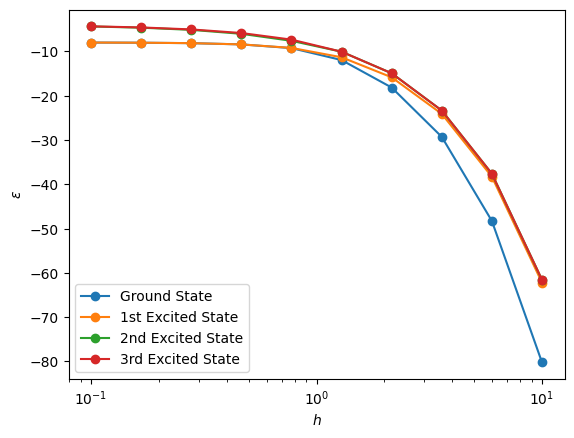

In [ ]:
plt.plot(hrange, gs, 'o-', label = 'Ground State')
plt.plot(hrange, es, 'o-', label = '1st Excited State')
plt.plot(hrange, es2, 'o-', label = '2nd Excited State')
plt.plot(hrange, es3, 'o-', label = '3rd Excited State')
plt.xlabel('$h$')
plt.ylabel('$\epsilon$')
plt.xscale('log')
plt.legend();

The gap is not exactly 0 at $h = 1$. This is due to finite size effects. If we plot the gap as a function of $L$ at $h = 1$, we will see it vanish.

In [ ]:
gap1 = []
gap2 = []
Ls = [4,6,8,10,12]
for L in Ls:
  H = J * Hbond_sparse(L) + Hfield_sparse(L)
  evals = np.linalg.eigvalsh(H.todense())
  gap1.append(evals[1] - evals[0])
  gap2.append(evals[2] - evals[0])

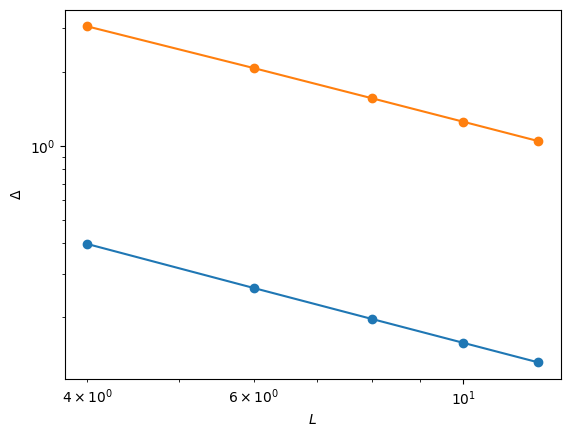

In [ ]:
plt.plot(Ls, gap1, 'o-')
plt.plot(Ls, gap2, 'o-')
plt.ylabel('$\Delta$')
plt.xlabel('$L$')
plt.yscale('log')
plt.xscale('log')

Note: The gap between the the lowest two eigenstates appears to be 0 all throughout the ferromagnetic phase.

### A brief primer on the TFIM

The Hamiltonian of the transverse field Ising model in 1D is

$H = -J\sum_i Z_iZ_{i+1} - h\sum_i X_i$.

This Hamiltonian commutes with the following operator: $\Pi_i^L X_i$. The action of this operator is to flip every spin in the $Z$ basis and as a result, this Hamiltonian has an overall spin flip symmetry (or $Z_2$ symmetry). Hamiltonians with symmetries cannot mix states between different symmetry sectors. That is to say, the dynamics of the two symmetry sectors are completely decoupled. As a result, we often care about the eigenvalues and eigenvectors of symmetry sectors separately. This Hamiltonian undergoes a phase transition as the ratio of $h/J$ is tuned.

**Ferromagnetic Phase:** When $h/J < 1$, this model is in a ferromagnetic phase, characterized by long range order of $Z$ basis magnetization. In the limit where $h \to 0$, there are two ground states of this Hamiltonian which respect the symmetry: $|G_{\pm}\rangle = \frac{|\uparrow \uparrow \ldots \rangle \pm |\downarrow \downarrow \ldots \rangle}{\sqrt{2}}$. One of these states ($G_+$) is symmetric under an overall spin flip, and the other ($G_-$) is antisymmetric. So, $G_+$ is the ground state of the Hamiltonian in the $Z_2$ symmetric symmetry sector and $G_-$ is the ground state of the Hamiltonian in the $Z_2$ antisymmetric symmetry sector.

Notice that these two states are global superposition states. Such global superposition states are often referred to as cat states. In QI language, these are also GHZ states. When $h=0$, these two states are exactly degenerate, which one can see by taking the expectation value with the Hamiltonian. For small $h$ however, these states become split in energy. This splitting may be estimated in perturbation theory: $\langle G_-| (-h \sum_i X_i )^n | G_+ \rangle$. However, unless $X_i$ acts on every spin, the state produced will be orthogonal to $G_-$. Therefore, we can see that the first order of perturbation theory which contributes to the energy is order $L$, indicating that the splitting in energy between $G_+$ and $G_-$ is exponentially small in system size, $\sim (h/J)^L$. Indeed, because these two cat states (which are eigenstates of the symmetry) become degenerate in the $L\rightarrow \infty$ limit, we can pick any superposition of them as the ground state, including the familar `all-up' and `all-down' states. These `all-up' and `all-down' states do not respect the Ising symmetry, which is why the fact that these can be chosen ground states is a manifestation of ``spontaneous symmetry breaking".

**Paramagnetic Phase:** When $h/J > 1$ the model is in the paramagnetic phase. In the limit where $J \to 0$, the ground state of the Hamiltonian is $|++\ldots \rangle$. That is, all spins pointing up in the $X$ direction. In this phase, there is no longer a degeneracy in the ground state manifold. This ground state belongs to the symmetric symmetry sector. The antisymmetric sector requires an odd number of spins pointing down in the $X$ direction, so this ground state will be the state with a single spin flipped down in the $X$ basis. Note that that an odd number of spins pointing down in the $X$ basis in the antisymmetric sector comes from the fact that the spin flip operator picks up a minus sign for each spin pointing downwards in the $X$ basis.

**Gaps:** There are multiple quantities that are all referred to as "the gap" when people talk about the TFIM and this can often be confusing. There is the gap between the ground state and the first excited state *within a symmetry sector*, $\Delta_+$ for the symmetric sector and $\Delta_-$ for the antisymmetric sector. Then there is the gap between the ground states of the two symmetry sectors, $\Delta_\pm$. The behavior of each of these gaps can be understood intuitively.

First, let us consider each of these gaps within the ferromagnetic phase. The first excitation we may create on top of $G_+$ or $G_-$ is flipping a single spin the $Z$ basis in order to create a pair of domain walls (a single domain wall for open boundary conditions). Then, the symmetry sector gaps at $h=0$ should just be $\Delta_+ = \Delta_- = 4J$. This energy cost decreases as one gets closer to the paramagnetic phase and indeed vanishes at the transition when $h = J$. The other gap, $\Delta_\pm \sim (h/J)^L \rightarrow 0 $ in the $L\rightarrow \infty $ limit via the perturbation theory argument from above.

In the paramagnetic phase, excitations consist of spin flips in the $X$ basis. However, to remain in the symmetric or anti-symmetric sector, two spins must be flipped. We get that $\Delta_+ = 4h$. We have to be a little more careful for the antisymmetric sector though. There are $L$ places the spin could be flipped in the $X$ basis for the antisymmetric ground state. When $J$ is strictly 0, this leads to an $L$ fold degenerate ground state, but for any non-zero $J$, there is a small splitting in these ground states. $\Delta_-$ then corresponds to the splitting between the two lowest lying states of this manifold, and goes to 0 in the large system limit. Finally, $\Delta_\pm$ is merely the cost of a single flipped spin, which is $2h$.

These gaps can numerically most clearly be seen when diagonalizing with symmetries, but we can see this physics at play in the above plot. As $h \to 0$, the ground state and the first excited state both become degenerate. This is gap $\Delta_\pm$ going to 0. The second and third excited states are the states with domain walls, and the energy gap seen numerically is $\sim 4$, which is in rough agreement with our estimate of $\Delta_+$ and $\Delta_-$.

In the paramagnetic phase, the ground state separates from the first excited state, which becomes nearly degenerate with the second and third excited states. The apparent degeneracy of the first,second and third excited states comes from the ground state manifold of the antisymmetric sector that we mentioned. We would have to plot $\mathcal{O}(L)$ states to get $\Delta_+$ but we can see that $\Delta_\pm \sim 2h$ at the largest value of $h$ in the plot and $\Delta_- \sim 0$.


Thus, if we define the gap as $\Delta_{\pm}$, it is finite everywhere in the paramagnet, it goes to zero (as a power law in $1/L$) at the critical point $h=1$, and goes to zero exponentially in $L$ in the ferromagnetic phase. If, instead, we consider the gap $\Delta_+$, we find that it is finite in both the paramagnetic and ferromagnetic phases, and goes to zero (as a power law in $1/L$) at the critical point.



Thus far, we only used sparse methods to construct the Hamiltonian, but thereafter proceeded to do full dense diagonalization to get the entire many-body spectrum. However, often one is interested in only the ground-state or a few low-lying states, in which case sparse eigensolvers can give a sizeable speedup.



```
import scipy.sparse.linalg as spalin
evals2, evecs2=spalin.eigsh(H, k=4, which='SA')
evals, evecs = linalg.eigh(H.toarray())
evals2
evals[0:4]
```



# Exercises (5pts)

In the following, assume that the system is described a chain of spin-$1/2$ particles of length $L$.

1. How do the run-times for sparse and dense matrix diagonalizations scale with $N$, the size of the matrix? Is sparse diagonalization always faster? If not, how large does $L$ have to be for sparse methods to win? (Hint: you many find the timeit module useful) (3 pts)
2. The toarray() function converts the sparse matrix to a dense numpy array. How much memory do you need to store such an array as a function of $L$? (1pt)
3. What is the maximum $L$ you can diagonalize on your laptop (you will need to check how much RAM you have)? (1pt)

**1.** We can calculate the diagonalization times using the time module.

In [ ]:
import time
import scipy.sparse.linalg as spalin

Ls = [4,6,8,10]
ED_times = []
sparse_times = []

for L in Ls:
  print(f'Diagonalizing Size {L}')
  H = Hbond_sparse(L) + Hfield_sparse(L)
  start = time.time()
  evals, evecs = spalin.eigsh(H, k=4, which='SA')
  end = time.time()
  sparse_times.append(end - start)
  if L <= 12:
    start = time.time()
    evals, evecs = np.linalg.eigh(H.todense())
    end = time.time()
    ED_times.append(end - start)

Diagonalizing Size 4
Diagonalizing Size 6
Diagonalizing Size 8
Diagonalizing Size 10


Text(0, 0.5, '$\\log t_{diag}$')

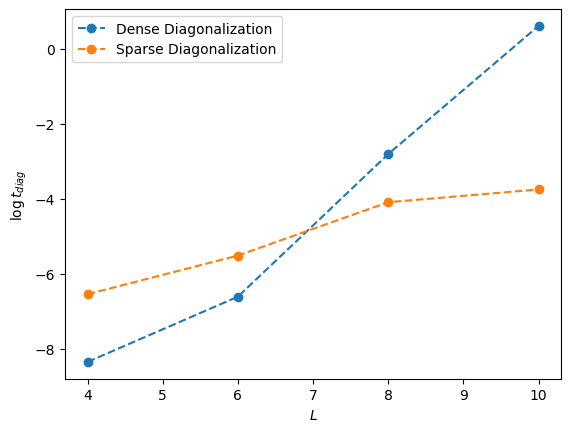

In [ ]:
plt.plot([4,6,8,10], np.log(ED_times), 'o--', label = 'Dense Diagonalization')
plt.plot(Ls, np.log(sparse_times), 'o--', label = 'Sparse Diagonalization')
plt.legend();
plt.xlabel('$L$')
plt.ylabel('$\log t_{diag}$')


Sparse matrix diagonalization apparently is much quicker as $L$ increases. The time complexity of dense matrix diagonalization is $\mathcal{O}(N^3)$, where $N$ is the matrix dimension. But, $N = 2^L$ so we get the time complexity to be $\mathcal{O}(2^{3L})$. On the other hand, sparse matrix diagonalization has a complexity which is $\mathcal{O}(kN^2 + Nk^2) = \mathcal{O}(k2^{2L}+ 2^Lk^2)$. We see that dense diagonalization is only better for very small $L$. Note, there are corrections to these time complexities depending on sparse diagonalization method and whether the matrix entries are real or complex.

**2.** A single float uses 4 bytes of data. A matrix on a size $L$ system has $4^L$ entries, requiring $4^{L+1}$ bytes. When $L = 4$, this requires ~0.001 MB. When $L = 8$, this requires ~0.26 MB. When $L = 12$, this requires about ~67 MB. When $L=16$, this requires ~17GB.

**3.** My laptop has only 16 GB so in theory the maximum size system I could diagonalize is $L=15$. Even then, of the 16GB of memory, not all of it can be used to just store a matrix so probably best I can do is $L=14$.